In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import ML_util
from utils.hideen_prints import HiddenPrints
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
import shap

from constants import SPATIAL, MORPHOLOGICAL, TEMPORAL, SPAT_TEMPO, STARK_SPAT, STARK_SPAT_TEMPO, STARK
from constants import WIDTH, T2P, WIDTH_SPAT, T2P_SPAT
from constants import TRANS_MORPH
from constants import INF
from run_tests import get_test_set

from features.spatial_features_calc import get_spatial_features_names
from features.morphological_features_calc import get_morphological_features_names
from features.temporal_features_calc import get_temporal_features_names

In [3]:
chunks = ['0', '500', '200']
modalities = ['spatial', 'temporal', 'spat_tempo', 'morphological']
NUM_FETS = 28

data_path = '../data_sets/'
models_path = '../saved_models/rf_regular_importance/'
restriction = 'complete'
dataset_identifier = '0.800.2'


model = 'rf'

In [4]:
def check_model(f, chunk_size, modality):
    splt = f.split('/')[-1].split('_')
    m1 = splt[1]
    m2 = m1 + '_' + splt[2]
    cs = splt[-1]
    return chunk_size == cs and (modality == m1 or modality == m2)
    

def load_models(path):
    files = [path + f for f in listdir(path) if isfile(join(path, f))]
    models = [[[] for _ in modalities] for _ in chunks]
    for i, chunk_size in enumerate(chunks):
        for j, modality in enumerate(modalities):
            cross_lst = [f for f in files if check_model(f, chunk_size, modality)]
            for model_path in cross_lst:
                with open(model_path, 'rb') as fid:
                    clf = pickle.load(fid)
                models[i][j].append(clf)
    return models

In [5]:
models = load_models(models_path)

In [6]:
def load_test_data(chunk_size, modality, seed, path):
    dataset_path = f"{path}{restriction}_{seed}/{modality}/{chunk_size}_{dataset_identifier}/"
    
    if modality == 'spatial':
        columns = get_spatial_features_names()
    elif modality == 'temporal':
        columns = get_temporal_features_names()[:-1]
    elif modality == 'spat_tempo':
        columns = get_spatial_features_names() + get_temporal_features_names()[:-1]
    elif modality == 'morphological':
        columns = get_morphological_features_names()[:-1]
    else:
        raise KeyError
    
    with HiddenPrints():
        test_fets, _ = get_test_set(dataset_path)
    
    df = pd.DataFrame(test_fets, columns=columns)
    X_shap = df.sample(min(1000, len(test_fets)), random_state=int(seed) + 1)
    
    return X_shap

explainers = [[[] for _ in modalities] for _ in chunks]
for i, chunk_size in enumerate(chunks):
    for j, modality in enumerate(modalities):
        for k, model in enumerate(models[i][j]):
            print(f"Now processing chunk_size={chunk_size}, modality={modality} and seed={k}")
            X_shap = load_test_data(chunk_size, modality, str(k), data_path)
            rf_explainer = shap.TreeExplainer(model)  # define explainer
            shap_values = rf_explainer(X_shap)  # calculate shap values
            pyr_shap_values = shap_values[..., 1]
            explainers[i][j].append(pyr_shap_values)

Now processing chunk_size=0, modality=spatial and seed=0
Now processing chunk_size=0, modality=spatial and seed=1
Now processing chunk_size=0, modality=spatial and seed=2
Now processing chunk_size=0, modality=spatial and seed=3
Now processing chunk_size=0, modality=spatial and seed=4
Now processing chunk_size=0, modality=spatial and seed=5
Now processing chunk_size=0, modality=spatial and seed=6
Now processing chunk_size=0, modality=spatial and seed=7
Now processing chunk_size=0, modality=spatial and seed=8
Now processing chunk_size=0, modality=spatial and seed=9
Now processing chunk_size=0, modality=spatial and seed=10
Now processing chunk_size=0, modality=spatial and seed=11
Now processing chunk_size=0, modality=spatial and seed=12
Now processing chunk_size=0, modality=spatial and seed=13
Now processing chunk_size=0, modality=spatial and seed=14
Now processing chunk_size=0, modality=spatial and seed=15
Now processing chunk_size=0, modality=spatial and seed=16
Now processing chunk_siz

Now processing chunk_size=500, modality=spat_tempo and seed=16
Now processing chunk_size=500, modality=spat_tempo and seed=17
Now processing chunk_size=500, modality=spat_tempo and seed=18
Now processing chunk_size=500, modality=spat_tempo and seed=19
Now processing chunk_size=500, modality=morphological and seed=0
Now processing chunk_size=500, modality=morphological and seed=1
Now processing chunk_size=500, modality=morphological and seed=2
Now processing chunk_size=500, modality=morphological and seed=3
Now processing chunk_size=500, modality=morphological and seed=4
Now processing chunk_size=500, modality=morphological and seed=5
Now processing chunk_size=500, modality=morphological and seed=6
Now processing chunk_size=500, modality=morphological and seed=7
Now processing chunk_size=500, modality=morphological and seed=8
Now processing chunk_size=500, modality=morphological and seed=9
Now processing chunk_size=500, modality=morphological and seed=10
Now processing chunk_size=500, m

In [7]:
fet_imports = [[] for _ in modalities]
sems = [[] for _ in modalities]

for i, modality in enumerate(modalities):
    for j, chunk_size in enumerate(chunks):
        exps = explainers[j][i]
        vals = []
        for exp in exps:
            vals.append(np.abs(exp.values))
        vals = np.abs(np.asarray(vals)).mean(axis=1)
        sem = vals.std(axis=0, ddof=1)
        vals = vals.mean(axis=0)
        fet_imports[i].append(vals)
        sems[i].append(sem)

for i in range(len(fet_imports)):
    fet_imports[i] = np.asarray(fet_imports[i])
    sems[i] = np.asarray(sems[i])


In [10]:
from plot_tests import autolabel

def plot_fet_imp(vals, sems):
    for i, m_name in enumerate(modalities):
        fet_names = explainers[0][i][0].feature_names
        
        vals_m = vals[i]
        sems_m = sems[i]

        order = np.argsort((-1 * vals_m).mean(axis=0))
        vals_m = vals_m[:, order]
        sems_m = sems_m[:, order]
        names_m = np.asarray(fet_names)[order]

        x = np.arange(len(names_m))  # the label locations

        v0, e0 = vals_m[0], sems_m[0]
        v500, e500 = vals_m[1], sems_m[1]
        v200, e200 = vals_m[2], sems_m[2]

        width = 0.3  # the width of the bars

        fig, ax = plt.subplots(figsize=(6, 12))
        rects1 = ax.bar(x - width, v0, width - 0.02, label='chunk_size = 0', yerr=e0, color='#404040',
                        edgecolor='k')
        rects2 = ax.bar(x, v500, width - 0.02, label='chunk_size = 500', yerr=e500, color='#808080',
                        edgecolor='k')
        rects3 = ax.bar(x + width, v200, width - 0.02, label='chunk_size = 200', yerr=e200,
                        color='#ffffff', edgecolor='k')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Importance')
        # ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(names_m, rotation=-25)
        ax.legend()

        fig.tight_layout()

        plt.show()

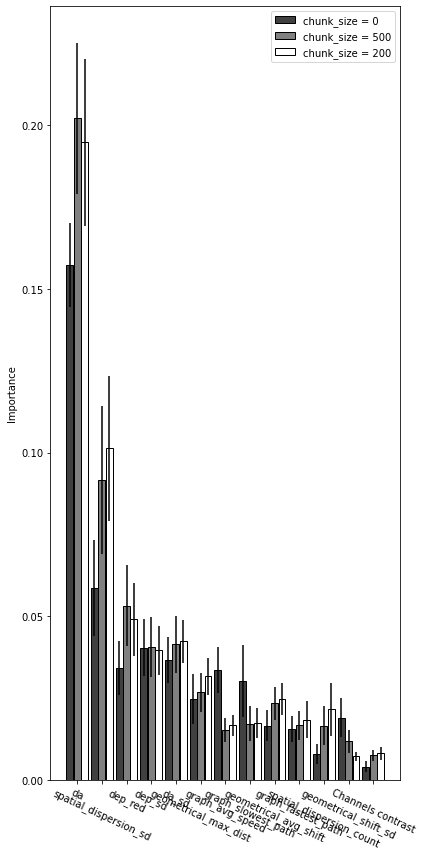

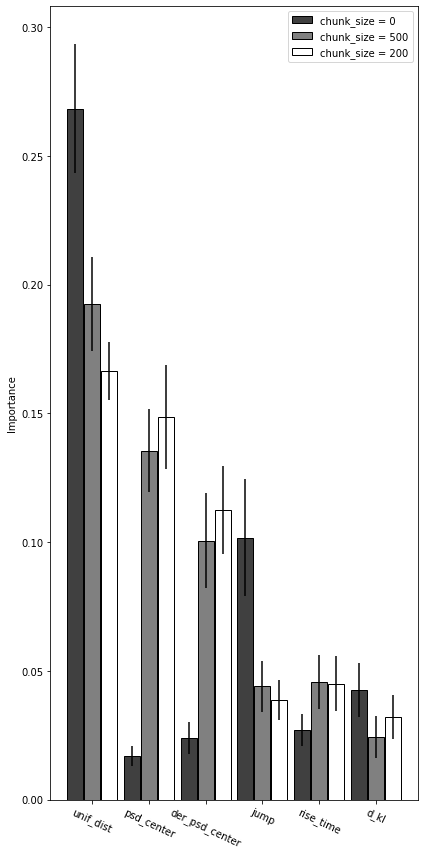

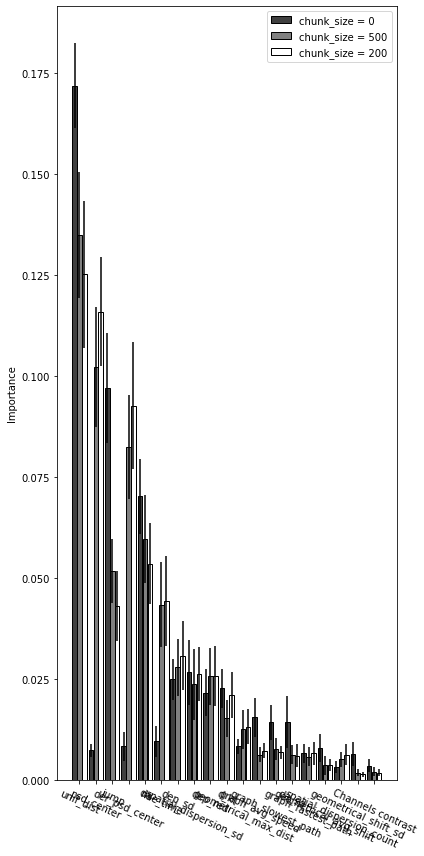

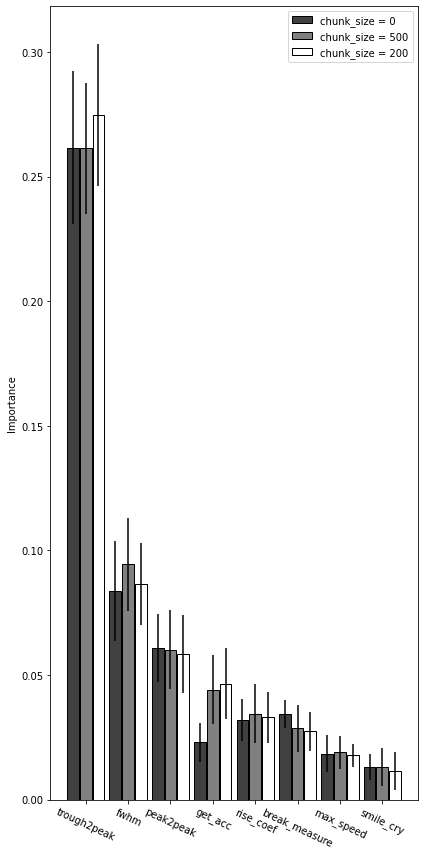

In [11]:
plot_fet_imp(fet_imports, sems)